In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../dataset/data3c.txt'
data0Label = r'../../dataset/data3clabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;
apram=1.0*pi
feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(apram*Parameter('x[0]'),0)
feature_map.rx(apram*Parameter('x[1]'),1)
feature_map.rx(apram*Parameter('x[2]'),2)
feature_map.rx(apram*Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [6]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [7]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

C:\Users\Saesun Kim\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


51.53718566894531
50.38766098022461
50.17333984375
50.02943801879883
50.013790130615234
50.007076263427734
50.00501251220703
50.004737854003906
50.0046501159668
50.004638671875
50.00455856323242
50.00446701049805
50.00434112548828
50.00422668457031
50.00410079956055
50.00395965576172
50.00380325317383
50.00377655029297
50.00366973876953
50.003658294677734


tensor(51.5372, grad_fn=<AddBackward0>)

Accuracy: 0.49


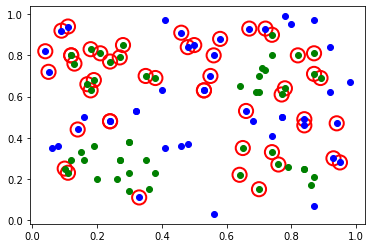

In [8]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

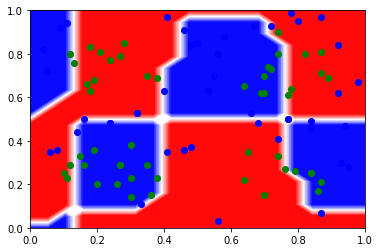

In [9]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [10]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = optim.SGD(model2.parameters(),lr=1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 50     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()


50.78102111816406
50.28252029418945
50.39515686035156
50.69563674926758
50.181861877441406
50.31914520263672
50.13576126098633
50.15382385253906
50.079559326171875
50.032596588134766
50.02044677734375
50.01095199584961
50.008277893066406
50.007022857666016
50.00653076171875
50.006248474121094
50.00605010986328
50.00587463378906
50.00571823120117
50.00558090209961
50.005455017089844
50.00534439086914
50.005226135253906
50.0051383972168
50.00504684448242
50.00495910644531
50.00486373901367
50.00480651855469
50.00473403930664
50.004669189453125
50.00460433959961
50.004539489746094
50.004478454589844
50.004432678222656
50.0043830871582
50.00434494018555
50.00429916381836
50.0042610168457
50.00419998168945
50.00416946411133
50.00413513183594
50.00409698486328
50.00407409667969
50.004024505615234
50.00399398803711
50.00396728515625
50.00392532348633
50.003902435302734
50.003883361816406
50.00386047363281


Accuracy: 0.5


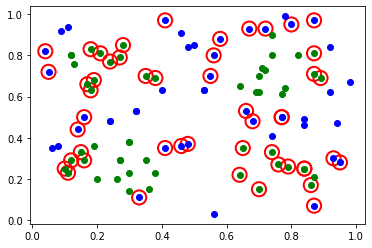

In [11]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

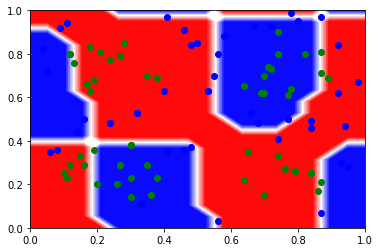

In [12]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [13]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define optimizer and loss function
optimizer = optim.Adam(model2.parameters(), lr=0.1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 100     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()

50.78237533569336
50.538326263427734
50.36422348022461
50.24393081665039
50.15727233886719
50.09477615356445
50.05235290527344
50.02692794799805
50.01657485961914
50.01787567138672
50.02519989013672
50.03369903564453
50.040740966796875
50.04487991333008
50.045066833496094
50.040767669677734
50.032264709472656
50.02145004272461
50.01179122924805
50.00667953491211
50.00669860839844
50.00933837890625
50.01162338256836
50.01227951049805
50.01151657104492
50.010169982910156
50.00883483886719
50.00771713256836
50.00673294067383
50.00581359863281
50.005062103271484
50.00456237792969
50.004302978515625
50.004207611083984
50.004180908203125
50.004188537597656
50.00415802001953
50.004154205322266
50.004119873046875
50.00408172607422
50.00402069091797
50.003910064697266
50.0037727355957
50.003604888916016
50.00345230102539
50.00328826904297
50.00315856933594
50.00302505493164
50.00288772583008
50.00271987915039
50.002540588378906
50.002384185791016
50.00221252441406
50.002079010009766
50.00198364

Accuracy: 0.32


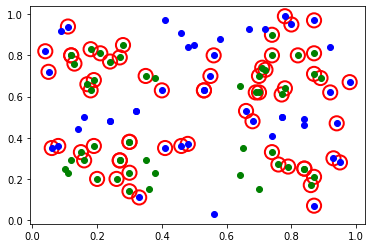

In [14]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

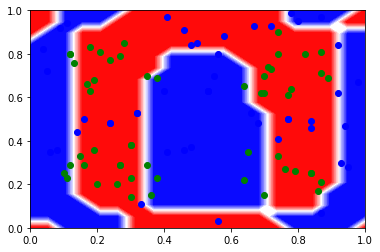

In [15]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)